In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


# LLava Set Up

## Download the repo

In [ ]:
# ! git clone https://github.com/haotian-liu/LLaVA.git /content/drive/MyDrive/llava

In [ ]:
import os
os.chdir("/content/drive/MyDrive/llava")

In [ ]:
! pip install --upgrade pip  # enable PEP 660 support
! pip install -e .

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 15.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
Obtaining file:///content/drive/MyDrive/llava
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Installing backend dependencies ... done
  Preparing editable metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.7/137.7 kB 7.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.2/244.2 kB 9.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 3.6 MB/s eta 0:00:

In [ ]:
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path
from llava.eval.run_llava import eval_model

model_path = "liuhaotian/llava-v1.5-7b"

tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path=model_path,
    model_base=None,
    model_name=get_model_name_from_path(model_path)
)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/749 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/438 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.16k [00:00<?, ?B/s]

You are using a model of type llava to instantiate a model of type llava_llama. This is not supported for all configurations of models and can yield errors.


pytorch_model.bin.index.json:   0%|          | 0.00/27.1k [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.54G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.76k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

## Help Functions

In [ ]:
import argparse
import torch
from llava.constants import (
    IMAGE_TOKEN_INDEX,
    DEFAULT_IMAGE_TOKEN,
    DEFAULT_IM_START_TOKEN,
    DEFAULT_IM_END_TOKEN,
    IMAGE_PLACEHOLDER,
)
from llava.conversation import conv_templates, SeparatorStyle
from llava.model.builder import load_pretrained_model
from llava.utils import disable_torch_init
from llava.mm_utils import (
    process_images,
    tokenizer_image_token,
    get_model_name_from_path,
)

from PIL import Image

import requests
from PIL import Image
from io import BytesIO
import re
# define my self eval model

def image_parser(args):
    out = args.image_file.split(args.sep)
    print(out)
    return out


def load_image(image_file):
    if image_file.startswith("http") or image_file.startswith("https"):
        response = requests.get(image_file)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_file).convert("RGB")
    return image


def load_images(image_files):
    out = []
    for image_file in image_files:
        image = load_image(image_file)
        out.append(image)
    return out

def eval_model(args):
    # Model
    disable_torch_init()
    tokenizer = args.tokenizer
    model = args.model
    image_processor = args.image_processor
    context_len = args.context_len

    # Image
    qs = args.query
    image_token_se = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_TOKEN + DEFAULT_IM_END_TOKEN
    if IMAGE_PLACEHOLDER in qs:
        if model.config.mm_use_im_start_end:
            qs = re.sub(IMAGE_PLACEHOLDER, image_token_se, qs)
        else:
            qs = re.sub(IMAGE_PLACEHOLDER, DEFAULT_IMAGE_TOKEN, qs)
    else:
        if model.config.mm_use_im_start_end:
            qs = image_token_se + "\n" + qs
        else:
            qs = DEFAULT_IMAGE_TOKEN + "\n" + qs

    conv_mode = "llava_v1"
    if args.conv_mode is not None and conv_mode != args.conv_mode:
        print(
            "[WARNING] the auto inferred conversation mode is {}, while `--conv-mode` is {}, using {}".format(
                conv_mode, args.conv_mode, args.conv_mode
            )
        )
    else:
        args.conv_mode = conv_mode

    conv = conv_templates[args.conv_mode].copy()
    conv.append_message(conv.roles[0], qs)
    conv.append_message(conv.roles[1], None)
    prompt = conv.get_prompt()

    # image_files = image_parser(args)
    # images = load_images(image_files)
    images = args.image_file

    image_sizes = [x.size for x in images]
    images_tensor = process_images(
        images,
        image_processor,
        model.config
    ).to(model.device, dtype=torch.float16)

    input_ids = (
        tokenizer_image_token(prompt, tokenizer, IMAGE_TOKEN_INDEX, return_tensors="pt")
        .unsqueeze(0)
        .cuda()
    )

    with torch.inference_mode():
        output_ids = model.generate(
            input_ids,
            images=images_tensor,
            image_sizes=image_sizes,
            do_sample=True if args.temperature > 0 else False,
            temperature=args.temperature,
            top_p=args.top_p,
            num_beams=args.num_beams,
            max_new_tokens=args.max_new_tokens,
            use_cache=True,
        )
    # print(output_ids)
    outputs = tokenizer.batch_decode(output_ids, skip_special_tokens=True)[0].strip()
    return outputs

# Evaluate

## Help Functions

In [ ]:
import random
import pickle
import matplotlib.pyplot as plt
import torch
from PIL import Image
import os
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.metrics import confusion_matrix as sklearn_confusion_matrix

In [ ]:
random.seed(1500)

def get_random_images(dataset_folder, sample_size=10):
    categories = os.listdir(dataset_folder)
    result_images = []
    category_size = int(sample_size/len(categories))
    if category_size < 1:
        category_size = 1

    for category in categories:
        category_path = os.path.join(dataset_folder, category)
        images = [os.path.join(category_path, img) for img in os.listdir(category_path) if img.endswith(('.jpg', '.png'))]
        #sample from each category
        sampled_images = random.sample(images, category_size)
        result_images.extend(sampled_images)

    return result_images

In [ ]:
def get_image_description(image_path,query):
    raw_image = Image.open(image_path).convert('RGB')
    # print(raw_image)
    all_output = []
    # for single_image in [raw_image]:
    args = type('Args', (), {
    "tokenizer": tokenizer,
    "model": model,
    "image_processor": image_processor,
    "context_len": context_len,
    "model_name": get_model_name_from_path(model_path),
    "query": query,
    "conv_mode": None,
    "image_file": [raw_image],
    "sep": ",",
    "temperature": 0.5,
    "top_p": None,
    "num_beams": 1,
    "max_new_tokens": 512
    })()
    output = eval_model(args)
      # all_output.append(output)
    # print("output is:", output)
    return output


def visualize_accuracy(labels, predicted_classes, categories):
    # Calculate accuracy for each category
    category_accuracies = {category: 0 for category in categories}
    for label, predicted_class in zip(labels, predicted_classes):
        if label == predicted_class:
            category_accuracies[label] += 1
    i = len(labels)
    # Normalize accuracy to get percentages
    total_images_per_category = len(labels) // len(categories)
    category_accuracies = {category: accuracy / total_images_per_category * 100 for category, accuracy in category_accuracies.items()}

    # Create a bar plot
    plt.bar(category_accuracies.keys(), category_accuracies.values(), color='blue')
    plt.xlabel('Categories')
    plt.ylabel('Accuracy (%)')
    plt.title('Accuracy for Each Category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f"/content/drive/MyDrive/Fig/accuracy_llava{i}.png")
    plt.show()


    return category_accuracies

In [ ]:
def plot_confusion_matrix(actual_classes, predicted_classes, i, name='Euro'):
    # Ensure unique labels are sorted or in a consistent order if necessary
    labels = sorted(set(predicted_classes + actual_classes))
    labels = [label[:20] for label in labels]  # Truncate label to no more than 20 characters
    ConfusionMatrixDisplay.from_predictions(actual_classes, predicted_classes, display_labels=labels, xticks_rotation='vertical')
    accuracy = accuracy_score(actual_classes, predicted_classes)
    plt.tight_layout()
    plt.title(f"Confusion Matrix {i} - Accuracy: {accuracy:0,.2f}")
    plt.savefig(f'/content/drive/MyDrive/Fig/confusionmatrix_llava{i}_{name}.png')
    plt.show()
    return accuracy

## EuroSAT

100%|██████████| 2000/2000 [25:14<00:00,  1.32it/s]


Predicted: ['River', 'River', 'River', 'Highway', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'Residential', 'River', 'River', 'River', 'River', 'Annual Crop', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'Annual Crop', 'River', 'River', 'River', 'River', 'River', 'Pasture', 'River', 'Pasture', 'River', 'Annual Crop', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'Annual Crop', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'Forest', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'Annual Crop', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'Annual Crop', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'River', 'Pasture', 'River', 'River', 'River', 'River', 'River', 'River', 'Annual Crop', 'River', 'Ann

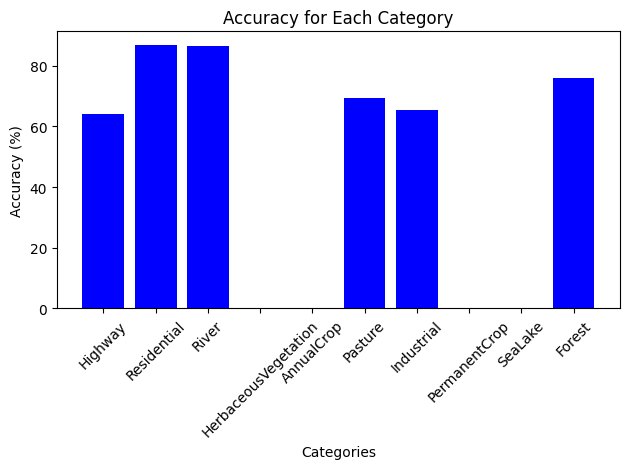

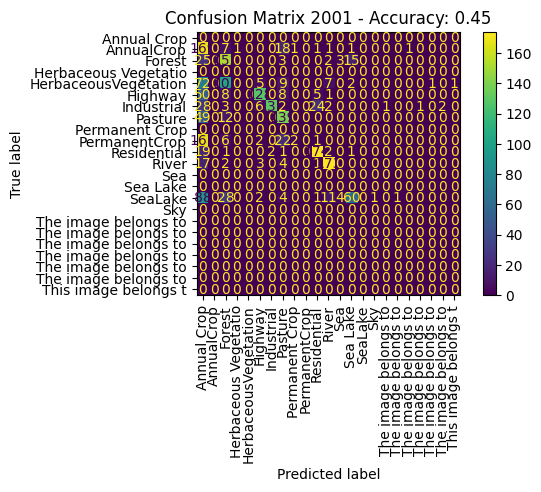

accuracy_conf: 0.4485


In [ ]:
from tqdm import tqdm

dataset_folder = "/content/drive/MyDrive/Datasets/EuroSAT/eurosat/2750"
results_folder = "/content/drive/MyDrive/Results"
sample_size = 2001 # minmum is 10 to get 1 image in each category
query = "This image belongs to one of the following classifications: Annual Crop, Forest, Herbaceous Vegetation, Highway, Industrial, Pasture, Permanent Crop, Residential, River, Sea Lake. Identify which of the provided classifications you think the image belongs to."
# Get random images
random_images = get_random_images(dataset_folder, sample_size)
# Get labels
labels = [img.split('/')[-2] for img in random_images]

# Get predicted classes from GPT-4
predicted_classes = []
for img in tqdm(random_images):
    predicted_classes.append(get_image_description(img,query))
print("Predicted:", predicted_classes)
print("Acutal:", labels)

correct_count = sum(labels == predicted_classes for labels, predicted_classes in zip(labels, predicted_classes))
accuracy = correct_count/sample_size
print("Sample Size:", sample_size)
print("Accuracy:", accuracy)

# Visualize accuracy for each category
categories = set(labels)
category_accuracy = visualize_accuracy(labels, predicted_classes, categories)

i=sample_size
accuracy_conf = plot_confusion_matrix(labels, predicted_classes, i)
print("accuracy_conf:", accuracy_conf)

# Save in dictionary
response_dict = dict(zip(random_images, predicted_classes))
with open(results_folder + f"/response_dict{sample_size}.pkl", 'wb') as file:
    pickle.dump(response_dict, file)

with open(results_folder + f"/cat_acc{sample_size}.pkl", 'wb') as file:
    pickle.dump(category_accuracy, file)

In [ ]:
import numpy as np
np.save("/content/drive/MyDrive/Results/predict_llava.npy", predicted_classes)
np.save("/content/drive/MyDrive/Results/label_llava.npy", labels)

## AID test

In [ ]:
from tqdm import tqdm

dataset_folder = "/content/drive/MyDrive/Datasets/Train_Test_Splits_AID/train"
results_folder = "/content/drive/MyDrive/Results/AID_LLAVA"
sample_size = 2001 # minmum is 10 to get 1 image in each category
query = "This image belongs to one of the following classifications: airport, bare land, baseball field, beach, bridge, center, church, commercial, dense residential, desert, farmland, forest, industrial, meadow, medium residential, mountain, park, parking, playground, pond, port, railway station, resort, river, school, sparse residential, square, stadium, storage tanks, viaduct. Identify which of the provided classifications you think the image belongs to."
# Get random images
random_images = get_random_images(dataset_folder, sample_size)
# Get labels
labels = [img.split('/')[-2] for img in random_images]

# Get predicted classes from GPT-4
predicted_classes = []
for img in tqdm(random_images):
    predicted_classes.append(get_image_description(img,query))
print("Predicted:", predicted_classes)
print("Acutal:", labels)

Sample Size: 2001
Accuracy: 0.3708145927036482


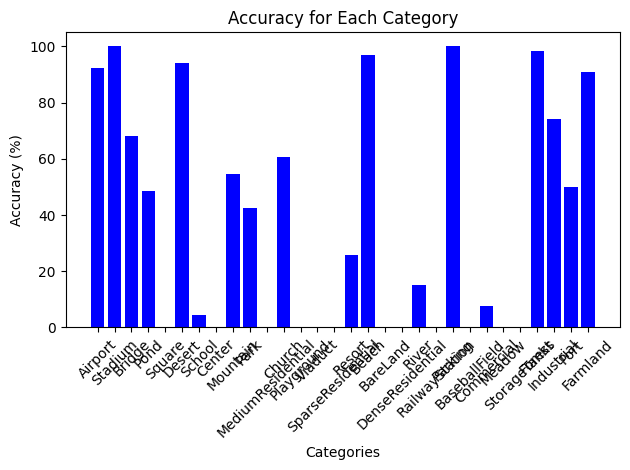

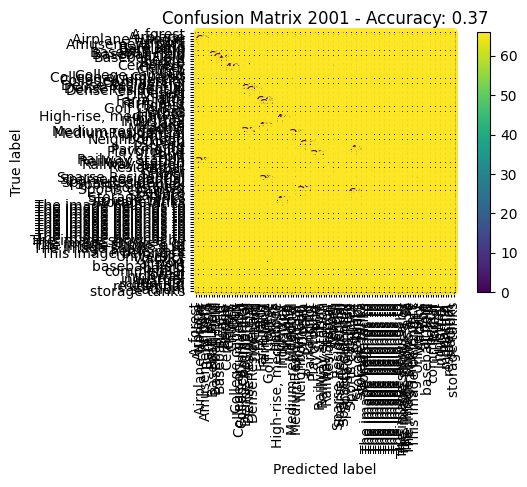

accuracy_conf: 0.3747474747474748


In [ ]:

correct_count = sum(labels == predicted_classes for labels, predicted_classes in zip(labels, predicted_classes))
accuracy = correct_count/sample_size
print("Sample Size:", sample_size)
print("Accuracy:", accuracy)

# Visualize accuracy for each category
categories = set(labels)
category_accuracy = visualize_accuracy(labels, predicted_classes, categories)

i=sample_size
accuracy_conf = plot_confusion_matrix(labels, predicted_classes, i, name = 'AID')
print("accuracy_conf:", accuracy_conf)

# Save in dictionary
response_dict = dict(zip(random_images, predicted_classes))
# with open(results_folder + f"/response_dict{sample_size}.pkl", 'wb') as file:
#     pickle.dump(response_dict, file)

# with open(results_folder + f"/cat_acc{sample_size}.pkl", 'wb') as file:
#     pickle.dump(category_accuracy, file)

## Res

In [ ]:
dataset_folder = "/content/drive/MyDrive/Datasets/Train_Test_Splits_RESISC45/train"
results_folder = "/content/drive/MyDrive/Results/RESISC45"
sample_size = 2000 # minmum is 10 to get 1 image in each category
seed = 123
random.seed(seed)

# Get random images
random_images = get_random_images(dataset_folder, sample_size)
# Get labels
labels = [img.split('/')[-2].lower().replace('_', '') for img in random_images]

# Get predicted classes from GPT-4
predicted_classes = [get_image_description(img).replace(' ', '') for img in random_images]
print("Predicted:", predicted_classes)
print("Acutal:", labels)

correct_count = sum(labels == predicted_classes for labels, predicted_classes in zip(labels, predicted_classes))
accuracy = correct_count/sample_size
print("Sample Size:", sample_size)
print("Accuracy:", accuracy)

# Visualize accuracy for each category
categories = set(labels)
category_accuracy = visualize_accuracy(labels, predicted_classes, categories, seed)

accuracy_conf = plot_confusion_matrix(labels, predicted_classes, seed)
print("accuracy_conf:", accuracy_conf)
